In [ ]:
#从paddledetecion导出模型时要使用tools\export_mode.py这个文件
#具体参考https://paddledetection.readthedocs.io/advanced_tutorials/deploy/EXPORT_MODEL.html
#在paddledetecton目录下
!python tools\export_model.py -c configs\yolov3_mobilenet_v1_fruit.yml --output_dir=YoloFruit608 -o weights=output\yolov3_mobilenet_v1_fruit\best_model TestReader.inputs_def.image_shape=[3,608,608]

In [ ]:
#显示有哪些参数
#在paddledetecton\slim\prune目录下
!python prune.py -c ..\..\configs\yolov3_mobilenet_v1_fruit.yml --print_params

In [ ]:
#在paddledetecton\slim\prune目录下
!python prune.py -c ..\..\configs\yolov3_mobilenet_v1_fruit.yml --pruned_params "yolo_block.0.0.0.conv.weights,yolo_block.0.0.1.conv.weights,yolo_block.0.1.0.conv.weights" --pruned_ratios="0.2,0.3,0.4" -o pretrain_weights=YOUR_MODEL_PATH

In [ ]:
#在paddledetecton\slim\prune目录下
!python eval.py -c ..\..\configs\yolov3_mobilenet_v1_fruit.yml --pruned_params "yolo_block.0.0.0.conv.weights,yolo_block.0.0.1.conv.weights,yolo_block.0.1.0.conv.weights" --pruned_ratios="0.2,0.3,0.4" -o weights=output\yolov3_mobilenet_v1_fruit\model_final

In [ ]:
#在paddledetecton\slim\prune目录下
!python export_model.py -c ..\..\configs\yolov3_mobilenet_v1_fruit.yml --pruned_params "yolo_block.0.0.0.conv.weights,yolo_block.0.0.1.conv.weights,yolo_block.0.1.0.conv.weights" --pruned_ratios="0.2,0.3,0.4" -o weights=output\yolov3_mobilenet_v1_fruit\model_final

### 下面是离线动态量化，离线静态量化的例子官方只提供了mnist和imagenet，我再看看，读数据的部分还没搞好

In [ ]:
#在paddledetection\slim\quantization目录下
!python train.py --not_quant_pattern yolo_output --eval -c ..\..\configs\yolov3_mobilenet_v1_fruit.yml -o max_iters=30000 LearningRate.base_lr=0.0001 LearningRate.schedulers="[!PiecewiseDecay {gamma: 0.1, milestones: [10000]}]" pretrain_weights=YOUR_MODEL_PATH

In [ ]:
#在paddledetection\slim\quantization目录下
!python export_model.py --not_quant_pattern yolo_output -c ..\..\configs\yolov3_mobilenet_v1_fruit.yml -o weights=output\yolov3_mobilenet_v1_fruit\best_model

#### 从export出模型到在lite上跑起来，还有关键的一步，就是使用opt工具来转换模型。
#### 这里列出两种方法

In [ ]:
#一、直接下载opt工具
%cd work/
!wget https://paddlelite-data.bj.bcebos.com/model_optimize_tool/opt
!chmod a+x opt
!./opt --model_file=./__model__ --param_file=./__params__ --optimize_out_type=naive_buffer --optimize_out=pruneModel

In [ ]:
#二、使用opt的api,自己写一个python文件，当然，在这之前你还是需要安装它
!python liteopt.py --mf YoloFruit608\yolov3_mobilenet_v1_fruit\__model__ --hf YoloFruit608\yolov3_mobilenet_v1_fruit\__params__ --oo YoloFruit608\fruit608

### 下面就在树莓派上开始吧，全部按照paddle-lite-demo里的方式就能看到狗，自行车，车被识别出来了，这个默认的模型是在pascalvoc上的ssdmobilenet。  
### 运行时按照下面的格式：  
### ./object_detection_demo model_dir label_dir input_file output_file  
### 如果调用摄像头，则可以省略后面两个参数  
### 这里有一个坑，如果认真看了paddledetection导出模型的部分应该就可以避开
### paddledetection导出的yolo的模型有两个输入，图像，图像大小
### 在demo里面只给了第一个，也就是图像
### 所以还要提供第二个参数  ,不然会segmentation fault
  
### 我这里换了yolo的mobilenet，输入设定成608\*608的
![](https://ai-studio-static-online.cdn.bcebos.com/76f955a98f104bdc82e25b2bb57f30df1c2e7a1405184f44a016af09384c1ac1)  
（自行车没有了，要啥自行车）  
![](https://ai-studio-static-online.cdn.bcebos.com/d96f94e126754f829b9db9df72e740c05640f7de272d441db197356570d350c8)
### 接着是量化后的效果  
![](https://ai-studio-static-online.cdn.bcebos.com/98d7b09e3bec4b978a5d256a6f9b416a347ec2fdfd5e43b69ec3b87a79a3f813)  
## ？？？量化后反而能够识别出自行车了，（~~应该是范伟老师给的~~）
### 然后是剪枝的效果
![](https://ai-studio-static-online.cdn.bcebos.com/2c133b40e946403a85dcc9d5f6a0702a021a53c3e17c4a3e945bc5519d844776)  
### 好像有点问题，我再查一下
### 可见，量化不仅提升了速度还提升了准确度 
 
#### 试了试把输入缩小到320\*320的  
![](https://ai-studio-static-online.cdn.bcebos.com/dada1ebd94ea4701b2fc38e0fc539cd9c734a1ad7f5f4701b386c46547c4b980)  
#### 320\*320的量化  
![](https://ai-studio-static-online.cdn.bcebos.com/0b932bffefad46c48f3b5affe783c3fb9b12b8948e584498980bf3eccba0dc34)  
#### 感谢这个项目，让我把去年双十一淘的树莓派翻出来用:-)哈哈哈哈

In [1]:
!pip install paddleslim -i https://pypi.org/simple

     |████████████████████████████████| 153kB 12kB/s eta 0:00:011


In [ ]:
#敏感度分析
!nohup python slim/sensitive/sensitive.py -c configs/yolov3_mobilenet_v1_voc.yml -o pretrain_weights=output/yolov3_mobilenet_v1_voc/ --pruned_params "yolo_block.0.0.0.conv.weights,yolo_block.0.0.1.conv.weights,yolo_block.0.1.0.conv.weights,yolo_block.0.1.1.conv.weights,yolo_block.0.2.conv.weights,yolo_block.0.tip.conv.weights,yolo_block.1.0.0.conv.weights,yolo_block.1.0.1.conv.weights,yolo_block.1.1.0.conv.weights,yolo_block.1.1.1.conv.weights,yolo_block.1.2.conv.weights,yolo_block.1.tip.conv.weights,yolo_block.2.0.0.conv.weights,yolo_block.2.0.1.conv.weights,yolo_block.2.1.0.conv.weights,yolo_block.2.1.1.conv.weights,yolo_block.2.2.conv.weights,yolo_block.2.tip.conv.weights" --sensitivities_file "./demo.data"
#得到demo.data文件，这个步骤会用到GPU
#这里提供我跑出来的demodemo.data文件

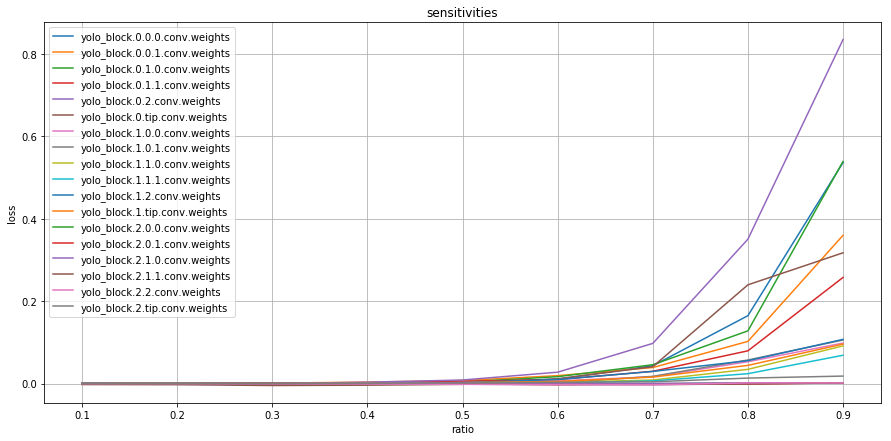

In [11]:
#画出折线图
import matplotlib.pyplot as plt
import numpy as np
import paddle
import paddleslim

sensitivities_data = paddleslim.prune.load_sensitivities("/home/aistudio/work/demo.data")


plt.figure(figsize=(15,7))

#group_labels = ['64k', '128k','256k','512k','1024k','2048k','4096k','8M','16M','32M','64M','128M','256M','512M']
plt.title('sensitivities')
plt.xlabel('ratio')
plt.ylabel('loss')

llist = []

for name in sensitivities_data.keys():
    l, = plt.plot(list(sensitivities_data[name].keys()), list(sensitivities_data[name].values()), label=name)
    llist.append(l)

plt.legend(handles = llist, labels = list(sensitivities_data.keys()), loc ='best')

#plt.xticks(sensitivities_data['yolo_block.0.0.0.conv.weights'], group_labels, rotation=0)
 
plt.grid()
plt.show()

In [15]:
#根据敏感度和精度损失阈值计算出一组剪切率。对于参数 w , 其剪裁率为使精度损失低于 loss 的最大剪裁率。
pruneres = paddleslim.prune.get_ratios_by_loss(sensitivities_data, 0.05)
print(pruneres)

{'yolo_block.0.0.0.conv.weights': 0.7057014807263885, 'yolo_block.0.0.1.conv.weights': 0.717632893141462, 'yolo_block.0.1.0.conv.weights': 0.7052692891458542, 'yolo_block.0.1.1.conv.weights': 0.740832270382253, 'yolo_block.0.2.conv.weights': 0.632085311172404, 'yolo_block.0.tip.conv.weights': 0.704587913395746, 'yolo_block.1.0.0.conv.weights': 0.7918929025320401, 'yolo_block.1.0.1.conv.weights': 0.7818544187891645, 'yolo_block.1.1.0.conv.weights': 0.8273142433451611, 'yolo_block.1.1.1.conv.weights': 0.8583151513101674, 'yolo_block.1.2.conv.weights': 0.7789350320691356, 'yolo_block.1.tip.conv.weights': 0.8114315065250017, 'yolo_block.2.0.0.conv.weights': 0.9, 'yolo_block.2.0.1.conv.weights': 0.9, 'yolo_block.2.1.0.conv.weights': 0.9, 'yolo_block.2.1.1.conv.weights': 0.9, 'yolo_block.2.2.conv.weights': 0.9, 'yolo_block.2.tip.conv.weights': 0.9}


In [ ]:
#total FLOPs: 24209088.0; pruned FLOPs: 5279241.0
#Best test box ap: 68.74477985953163, in iter: 66000